# Q-Learning: Continuous Example with MountainCar

**Mountain Car** is a very famous testbed published by Moore in 1990. From the OpenAI Gym website on [MountainCar](https://gym.openai.com/envs/MountainCar-v0/):

"A car is on a one-dimensional track, positioned between two mountains. The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum."

Note that:
- There is gravity
- We have a single position variable in X axis; 0 appears to be the valley, 0.5 the flag
- The goal is to directly land the falg, no less, no more!

Links:
- [MountainCar-v0](https://gym.openai.com/envs/MountainCar-v0/)
- [Github link](https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py)

This notebook uses basically the same code (modified for the environment) as in `02_2_QLearning_Continuous_Cartpole.ipynb`.

Overview of the notebook contents:
1. Instantiate Environment
2. Discretize State Space
3. Q Table
4. Functions and Hyperparameters



## 1. Instantiate Environment

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [6]:
env = gym.make("MountainCar-v0")

## 2. Discretize State Space

In [21]:
# We create ranges/bins for all observations
# The more bins we have, the more accurate the system will be
# but the more it is going to require to learn
# For ranges of observations, look at the environment link
# https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py
def create_bins(num_bins_obs = 10):
    # Note that a bin vector with 6 range values leads to 6-1=5 bins!
    # Therefore, if we want n bins, linspace needs to create n+1 range values
    #n = num_bins_obs
    n = num_bins_obs+1
    bins_car_pos = np.linspace(-1.2,0.6,n)
    bins_car_vel = np.linspace(-0.7,0.7,n)
    bins = np.array([bins_car_pos,
                     bins_car_vel])
    return bins

In [22]:
NUM_BINS = 40 # Take at least 10
BINS = create_bins(NUM_BINS)

In [23]:
BINS

array([[-1.2  , -1.155, -1.11 , -1.065, -1.02 , -0.975, -0.93 , -0.885,
        -0.84 , -0.795, -0.75 , -0.705, -0.66 , -0.615, -0.57 , -0.525,
        -0.48 , -0.435, -0.39 , -0.345, -0.3  , -0.255, -0.21 , -0.165,
        -0.12 , -0.075, -0.03 ,  0.015,  0.06 ,  0.105,  0.15 ,  0.195,
         0.24 ,  0.285,  0.33 ,  0.375,  0.42 ,  0.465,  0.51 ,  0.555,
         0.6  ],
       [-0.7  , -0.665, -0.63 , -0.595, -0.56 , -0.525, -0.49 , -0.455,
        -0.42 , -0.385, -0.35 , -0.315, -0.28 , -0.245, -0.21 , -0.175,
        -0.14 , -0.105, -0.07 , -0.035,  0.   ,  0.035,  0.07 ,  0.105,
         0.14 ,  0.175,  0.21 ,  0.245,  0.28 ,  0.315,  0.35 ,  0.385,
         0.42 ,  0.455,  0.49 ,  0.525,  0.56 ,  0.595,  0.63 ,  0.665,
         0.7  ]])

In [24]:
BINS.shape

(2, 41)

In [12]:
# We create a function that uses that digitize utility
def discretize_observation(observations,bins):
    # bin indices for the observations
    binned_observations = []
    for i,observation in enumerate(observations):
        discretized_observation = np.digitize(observation,bins[i,:])
        # np.discretize() yields indices starting at 1
        # thus, we need to decrease it
        discretized_observation = discretized_observation-1
        # check that we are in range: index in [0,NUM_BINS-1]
        if discretized_observation < 0:
            discretized_observation = 0
        # recall BINS/bins contains n+1 range values, n being the number of bins
        # thus, we substract 2 units
        elif discretized_observation > bins.shape[1]-2:
            discretized_observation = bins.shape[1]-2
        binned_observations.append(discretized_observation)
    return tuple(binned_observations)

In [13]:
observations = env.reset()

In [14]:
observations

array([-0.4899612,  0.       ], dtype=float32)

In [15]:
discretize_observation(observations,BINS)

(15, 20)

## 3. Q Table

Each observation (we have `2`) adds a dimension of size `NUM_BINS` and we have an extra dimension for the actions of size `num_actions`.

In [18]:
q_table_shape = (NUM_BINS,NUM_BINS,env.action_space.n)

In [19]:
q_table = np.zeros(q_table_shape)

In [20]:
q_table.shape

(40, 40, 3)

## 4. Functions and Hyperparameters

In [33]:
# Hyperparameters
EPOCHS = 30000
ALPHA = 0.8
GAMMA = 0.9

In [34]:
# Epsilon greedy action selection
def epsilon_greedy_action_selection(epsilon,q_table,discrete_state):
    random_number = np.random.random()
    # Exploitation: choose action that maximizes Q
    if random_number > epsilon:
        # Grab state action row, with all Q values
        state_row = q_table[discrete_state]
        # Select the action index which has the largest Q value
        action = np.argmax(state_row)
    # Exploration: choose a random action
    else:
        action = env.action_space.sample()
    return action

In [35]:
# Q-Learning update equation
# Q_next = Q_old + ALPHA*Q_error
# Q_error = reward + GAMMA*Q_optimum - Q_old
def compute_next_q_value(old_q_value,reward,next_optimal_q_value):
    Q_error = reward + GAMMA*next_optimal_q_value - old_q_value
    Q_next = old_q_value + ALPHA*Q_error
    return Q_next

In [36]:
# Hyperparameters: epsilon (exploration vs exploitation)
EPSILON = 1.0
burn_in = 100
epsilon_end = 10000
#epsilon_reduce = 0.0001
epsilon_reduce = 1.0 / epsilon_end

In [37]:
# Epsilon exponential decay after each episode/epoch
def reduce_epsilon(epsilon,epoch):
    # Exponential decay
    #return min_epsilon + (max_epsilon-min_epsilon)*np.exp(-decay_rate*epoch)
    # Linear decay with a hard stop at a certain number of epochs
    if burn_in <= epoch <= epsilon_end:
        epsilon -= epsilon_reduce
    return epsilon

## 5. Training

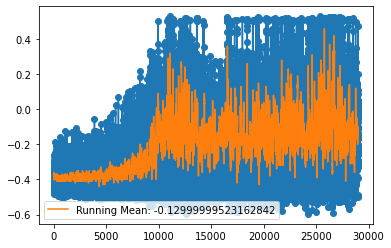

In [38]:
%matplotlib inline
log_interval = 1000
render_interval = 30000 # env.render()
####################################
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion() # interactive mode on
fig.canvas.draw()
####################################
max_position_log = []  # to store all achieved points
mean_positions_log = []  # to store a running mean of the last 30 results
epochs = []  # store the epoch for plotting
for epoch in range(EPOCHS):
    initial_state = env.reset()
    # Discretization
    discretized_state = discretize_observation(initial_state,BINS)
    done = False
    max_position = -np.inf  # for plotting
    epochs.append(epoch)
    # Play the game
    while not done:
        action = epsilon_greedy_action_selection(EPSILON,q_table,discretized_state)
        # state: [position, velocity]
        next_state,reward,done,info = env.step(action)
        position,velocity = next_state # for plotting
        # Discretization
        next_state_discretized = discretize_observation(next_state,BINS)
        # Tuple concatenation: (o1,o2) + (action,) -> (o1,o2,action)
        old_q_value = q_table[discretized_state + (action,)]
        next_optimal_q_value = np.max(q_table[next_state_discretized])
        next_q = compute_next_q_value(old_q_value,reward,next_optimal_q_value)
        q_table[discretized_state + (action,)] = next_q
        discretized_state = next_state_discretized
        if position > max_position:  # Only for plotting the results - store the highest point the car is able to reach
            max_position = position
    EPSILON = reduce_epsilon(EPSILON,epoch)
    max_position_log.append(max_position)  # log the highest position the car was able to reach
    running_mean = round(np.mean(max_position_log[-30:]), 2)  # Compute running mean of position over the last 30 epochs
    mean_positions_log.append(running_mean)  # and log it
    ####################################
    if epoch % log_interval == 0:
        #print(f"{episode} games played; accumulated reward: {np.sum(rewards)}")
        ax.clear()
        ax.scatter(epochs,max_position_log)
        ax.plot(epochs,max_position_log)
        ax.plot(epochs,mean_positions_log,label=f'Running Mean: {running_mean}')
        plt.legend()
        fig.canvas.draw()
    ####################################
env.close()

## 5. Utilization of the Learned Q Table

In [ ]:
observation = env.reset()
rewards = 0

for step in range(5000):
    env.render()
    discrete_state = discretize_observation(observation,BINS)
    action = np.argmax(q_table[discrete_state])
    observation,reward,done,info = env.step(action)
    rewards += reward
    if done:
        print(f'Reward points: {rewards}')
        break;
env.close()

In [ ]:
env.close()

Conclusion: It does not work :)
Solution: try other hyperparameters :)
- Reduce the amount of epochs
- Modify teh decay
- Try more steps; however, note that by default we are 'done' is 200 steps are executed
- ...